In [1]:
%matplotlib inline

import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import randint, uniform
from sklearn import linear_model, preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import (RandomForestRegressor)
from sklearn.linear_model import Lasso, LogisticRegression, Ridge
from sklearn.metrics import (classification_report, mean_absolute_error, r2_score)
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     train_test_split)
from sklearn.preprocessing import (LabelEncoder, MinMaxScaler, OneHotEncoder,
                                   PolynomialFeatures, RobustScaler,
                                   StandardScaler)
from sklearn.svm import SVC

pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)

In [2]:
# import data
dataset_og = pd.read_csv('..\Data\Measurements-Transformed')
# kopie maken indien we iets van de originele data nodig hebben
dataset = dataset_og.copy()
dataset.head(5)

,ID,Sex,Measurement_Age,Add,Sph-Far-R,Cyl-Far-R,Axis-Far-R,Sph-Close-R,Cyl-Close-R,Axis-Close-R,Sph-Far-L,Cyl-Far-L,Axis-Far-L,Sph-Close-L,Cyl-Close-L,Axis-Close-L
0,900546,0,21118,0.0,-1.75,0.5,55.0,-2.25,1.0,55.0,-1.75,1.0,110.0,-1.25,0.5,110.0
1,900546,0,20245,0.0,-1.75,0.5,65.0,0.00,0.0,0.0,-1.25,0.5,110.0,0.00,0.0,0.0
2,900546,0,18099,0.0,-1.50,0.5,65.0,0.00,0.0,0.0,-1.00,0.5,110.0,0.00,0.0,0.0
3,797627,1,6845,0.0,-1.50,0.5,170.0,0.00,0.0,0.0,-1.50,0.5,170.0,0.00,0.0,0.0
4,797627,1,5779,0.0,-0.75,0.5,170.0,0.00,0.0,0.0,-1.00,0.5,170.0,0.00,0.0,0.0


### Features:
Sex: geslacht

Measurement_Age:

Add: additie, is altijd gelijk in beide ogen

Sph-Far-R: sphere ver van rechter oog, zowel + als - waardes

Cyl-Far-R: cylinder ver van rechter oog, zowel + als - waardes

Axis-Far-R: as ver van rechteroog, waarde tussen 0 en 180

Sph-Close-R: sphere dicht van rechteroog = som van add + Sph-Far-R, zowel + als - waardes

Cyl-Close-R: cylinder dicht van rechteroog, zowel + als - waardes

Axis-Close-R: as dicht van rechteroog, waarde tussen 0 en 180

Sph-Far-L: sphere ver van linker oog, zowel + als - waardes

Cyl-Far-L: cylinder ver van linker oog, zowel + als - waardes

Axis-Far-L: as ver van linker oog, tussen 0 en 180

Sph-Close-L: sphere dicht van linker oog = som van add + Sph-Far-L, zowel + als - waardes

Cyl-Close-L: cylinder dicht van linker oog, zowel + als - waardes

Axis-Close-L: as dicht van linker oog, tussen 0 en 180

In [3]:
#??????????????
for coll in dataset.columns:
    coll = np.nan_to_num(coll)
pd.DataFrame(dataset).fillna(0, inplace=True)
np.where(np.isnan(dataset))

(array([], dtype=int64), array([], dtype=int64))

In [4]:
#drop rijen waar < n meting van zijn en houd van de overige de top n meest recente waardes
n = 2
dataset = dataset.groupby('ID').filter(lambda x: len(x) > (n-1))
dataset = dataset.groupby('ID').head(n)

In [5]:
dataset.head(6)

,ID,Sex,Measurement_Age,Add,Sph-Far-R,Cyl-Far-R,Axis-Far-R,Sph-Close-R,Cyl-Close-R,Axis-Close-R,Sph-Far-L,Cyl-Far-L,Axis-Far-L,Sph-Close-L,Cyl-Close-L,Axis-Close-L
0,900546,0,21118,0.00,-1.75,0.50,55.0,-2.25,1.00,55.0,-1.75,1.00,110.0,-1.25,0.50,110.0
1,900546,0,20245,0.00,-1.75,0.50,65.0,0.00,0.00,0.0,-1.25,0.50,110.0,0.00,0.00,0.0
3,797627,1,6845,0.00,-1.50,0.50,170.0,0.00,0.00,0.0,-1.50,0.50,170.0,0.00,0.00,0.0
4,797627,1,5779,0.00,-0.75,0.50,170.0,0.00,0.00,0.0,-1.00,0.50,170.0,0.00,0.00,0.0
5,710633,1,20777,2.25,3.75,0.75,5.0,2.00,0.25,5.0,-1.25,0.25,135.0,0.50,0.75,135.0
6,710633,1,19033,2.25,-1.25,0.00,0.0,1.00,0.00,0.0,-1.50,0.00,0.0,0.75,0.00,0.0


In [6]:
#weglaten van de minst gecorreleerde features
# dataset.drop(['Sex', 'Add', 'Axis-Close-R', 'Axis-Close-L'],axis=1, inplace=True)

# #2 rijen naast elkaar zetten

# dataset = dataset.merge(dataset ,on=['ID'], suffixes=['_x', ''])
# dataset = dataset.sort_values(by=['ID', 'Measurement_Age_x'])
# dataset = dataset.drop_duplicates(subset=['ID'], keep='first')
# dataset.head()

In [7]:
#2 rijen naast elkaar zetten

dataset = dataset.merge(dataset ,on=['ID', 'Sex'], suffixes=['_x', ''])
dataset = dataset.sort_values(by=['ID', 'Measurement_Age_x'])
dataset = dataset.drop_duplicates(subset=['ID', 'Sex'], keep='first')
dataset.head()

,ID,Sex,Measurement_Age_x,Add_x,Sph-Far-R_x,Cyl-Far-R_x,Axis-Far-R_x,Sph-Close-R_x,Cyl-Close-R_x,Axis-Close-R_x,Sph-Far-L_x,Cyl-Far-L_x,Axis-Far-L_x,Sph-Close-L_x,Cyl-Close-L_x,Axis-Close-L_x,Measurement_Age,Add,Sph-Far-R,Cyl-Far-R,Axis-Far-R,Sph-Close-R,Cyl-Close-R,Axis-Close-R,Sph-Far-L,Cyl-Far-L,Axis-Far-L,Sph-Close-L,Cyl-Close-L,Axis-Close-L
25648,100066,1,19342,0.0,-5.25,1.50,90.0,-5.25,1.5,90.0,-5.25,1.5,90.0,-5.25,1.5,90.0,19342,0.0,-5.25,1.50,90.0,-5.25,1.50,90.0,-5.25,1.50,90.0,-5.25,1.50,90.0
15230,100209,0,3368,0.0,-1.75,1.75,110.0,0.00,0.0,0.0,-0.50,0.5,90.0,0.00,0.0,0.0,3809,0.0,-1.25,1.25,95.0,-1.25,1.25,95.0,-0.25,0.25,90.0,-0.25,0.25,90.0
5922,100299,1,8132,0.0,-1.00,0.00,0.0,0.00,0.0,0.0,-0.75,0.0,0.0,0.00,0.0,0.0,10176,0.0,-1.25,0.00,0.0,-1.25,0.00,0.0,-0.75,0.00,0.0,-0.75,0.00,0.0
5226,100314,0,5249,0.0,-0.25,0.00,0.0,0.00,0.0,0.0,-0.25,0.0,0.0,0.00,0.0,0.0,6519,0.0,-0.75,0.00,0.0,-0.75,0.00,0.0,-0.75,0.00,0.0,-0.75,0.00,0.0
9158,100445,0,25293,0.0,0.00,0.00,0.0,1.00,0.0,20.0,0.00,0.0,0.0,1.00,0.5,0.0,27299,0.0,0.00,0.00,0.0,2.75,1.25,90.0,0.00,0.00,0.0,5.00,0.00,70.0


In [8]:
#Drop kolom ID
dataset.drop(['ID'],axis=1, inplace=True)


### Linear regression

In [9]:
# Splitsen in features en targets

y = dataset['Sph-Far-R'].values
X = dataset.drop(['Add', 'Sph-Far-R', 'Cyl-Far-R', 'Axis-Far-R', 'Sph-Close-R', 'Cyl-Close-R', 'Axis-Close-R', 'Sph-Far-L', 
                  'Cyl-Far-L', 'Axis-Far-L', 'Sph-Close-L', 'Cyl-Close-L', 'Axis-Close-L'],axis=1)

# Splitsen in training set en test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


## Standard scaler
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Linear regression

lreg_sph_far_r = linear_model.LinearRegression()
lreg_sph_far_r.fit(X_train,y_train)
print(lreg_sph_far_r.coef_)
r2 = lreg_sph_far_r.score(X_test,y_test)
print('r2 score = ', r2)

# Modeloptimalisatie en Hyperparameter tuning

# Aanmaken van de hogere orde features
graad = 2

poly = PolynomialFeatures(graad)
poly.fit(X_train)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)
print('dimensie van X_train_poly: ',X_train_poly.shape)
print('dimensie van X_test_poly: ',X_test_poly.shape)


# met L2 regularisatie via Ridge regression
lreg_poly_sph_far_r = Ridge(alpha=0.5,tol=0.0001,fit_intercept=True)
lreg_poly_sph_far_r.fit(X_train_poly,y_train)

print('R2 score op test set via L2: ',lreg_poly_sph_far_r.score(X_test_poly,y_test))
# R2 -score via L2 op de trainingset
print('R2 score op training set via L2: ',lreg_poly_sph_far_r.score(X_train_poly,y_train))


# # met L1 regularisatie via Lasso regression
# lreg_poly_sph_far_r = Lasso(alpha=0.001,tol=0.0001,fit_intercept=True)
# lreg_poly_sph_far_r.fit(X_train_poly,y_train)      
  
      
# print('R2 score op test set via L1: ',lreg_poly_sph_far_r.score(X_test_poly,y_test))
  
# # R2 -score via L1 op de trainingset
# print('R2 score op training set via L1: ',lreg_poly_sph_far_r.score(X_train_poly,y_train))    

# # Variëren van de alpha en grafiek

# train_r2 = []
# test_r2 = []


# alphas = np.logspace(-2, 6, 1000)

# for alpha in alphas:
#     lregmodel_poly = Ridge(alpha=alpha,tol=0.0001,fit_intercept=True)
#     lregmodel_poly.fit(X_train_poly,y_train)
#     test_r2.append(lregmodel_poly.score(X_test_poly,y_test))  
#     train_r2.append(lregmodel_poly.score(X_train_poly,y_train))


# # Plot r2
# f, ax = plt.subplots(figsize=(10, 8))
# plt.subplot(2, 1, 1)
# plt.semilogx(alphas, train_r2, label='Train')
# plt.semilogx(alphas, test_r2, label='Test')
# plt.legend(loc='lower left')
# plt.ylim([0, 1.2])
# plt.xlabel('Regularization parameter')
# plt.ylabel('R² Performance')



# Via KernelRidge met een polynomial kernel

# from sklearn.kernel_ridge import KernelRidge

# lreg_sph_far_r = KernelRidge(alpha=0.001, degree=3, gamma=None, kernel='polynomial')
# lreg_sph_far_r.fit(X_train,y_train)


# y_predicted = lreg_sph_far_r.predict(X_train)
# r2 = r2_score(y_train,y_predicted)

# print('training set: ',r2)

# y_predicted = lreg_sph_far_r.predict(X_test)
# r2 = r2_score(y_test,y_predicted)

# print('test set: ',r2)

[ 0.00918682 -0.28633455 -0.1713596   1.91368004  0.09049462 -0.08547377
  0.15850875 -0.07187467  0.0729412   0.45951896 -0.02067529 -0.04231607
  0.03013486  0.02476855  0.05906536  0.64997289]
r2 score =  0.7865558011527171
dimensie van X_train_poly:  (6833, 153)
dimensie van X_test_poly:  (1709, 153)
R2 score op test set via L2:  0.7999430644929254
R2 score op training set via L2:  0.8233100270748223


In [10]:
# Splitsen in features en targets

y = dataset['Cyl-Far-R'].values
X = dataset.drop(['Add', 'Sph-Far-R', 'Cyl-Far-R', 'Axis-Far-R', 'Sph-Close-R', 'Cyl-Close-R', 'Axis-Close-R', 'Sph-Far-L', 
                  'Cyl-Far-L', 'Axis-Far-L', 'Sph-Close-L', 'Cyl-Close-L', 'Axis-Close-L'],axis=1)

# Splitsen in training set en test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


## Standard scaler
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Linear regression

lreg_cyl_far_r = linear_model.LinearRegression()
lreg_cyl_far_r.fit(X_train,y_train)
print(lreg_cyl_far_r.coef_)
r2 = lreg_cyl_far_r.score(X_test,y_test)
print('r2 score = ', r2)

# Modeloptimalisatie en Hyperparameter tuning

# Aanmaken van de hogere orde features
graad = 2

poly = PolynomialFeatures(graad)
poly.fit(X_train)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)
print('dimensie van X_train_poly: ',X_train_poly.shape)
print('dimensie van X_test_poly: ',X_test_poly.shape)


# met L2 regularisatie via Ridge regression
lreg_poly_cyl_far_r = Ridge(alpha=0.5,tol=0.0001,fit_intercept=True)
lreg_poly_cyl_far_r.fit(X_train_poly,y_train)

print('R2 score op test set via L2: ',lreg_poly_cyl_far_r.score(X_test_poly,y_test))
# R2 -score via L2 op de trainingset
print('R2 score op training set via L2: ',lreg_poly_cyl_far_r.score(X_train_poly,y_train))

[ 0.0056063  -0.1671972  -0.03426157 -0.00327348  0.2808808  -0.02141647
  0.00713429  0.05735339  0.0195822  -0.01900861  0.03751697 -0.01613666
  0.02397751 -0.00614762  0.00963567  0.15799624]
r2 score =  0.5857827575788236
dimensie van X_train_poly:  (6833, 153)
dimensie van X_test_poly:  (1709, 153)
R2 score op test set via L2:  0.6080443534538483
R2 score op training set via L2:  0.6247270740132329


In [11]:
# Splitsen in features en targets

y = dataset['Sph-Far-L'].values
X = dataset.drop(['Add', 'Sph-Far-R', 'Cyl-Far-R', 'Axis-Far-R', 'Sph-Close-R', 'Cyl-Close-R', 'Axis-Close-R', 'Sph-Far-L', 
                  'Cyl-Far-L', 'Axis-Far-L', 'Sph-Close-L', 'Cyl-Close-L', 'Axis-Close-L'],axis=1)

# Splitsen in training set en test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


## Standard scaler
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Linear regression

lreg_sph_far_l = linear_model.LinearRegression()
lreg_sph_far_l.fit(X_train,y_train)
print(lreg_sph_far_l.coef_)
r2 = lreg_sph_far_l.score(X_test,y_test)
print('r2 score = ', r2)

# Modeloptimalisatie en Hyperparameter tuning

# Aanmaken van de hogere orde features
graad = 2

poly = PolynomialFeatures(graad)
poly.fit(X_train)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)
print('dimensie van X_train_poly: ',X_train_poly.shape)
print('dimensie van X_test_poly: ',X_test_poly.shape)


# met L2 regularisatie via Ridge regression
lreg_poly_sph_far_l = Ridge(alpha=0.5,tol=0.0001,fit_intercept=True)
lreg_poly_sph_far_l.fit(X_train_poly,y_train)

print('R2 score op test set via L2: ',lreg_poly_sph_far_l.score(X_test_poly,y_test))
# R2 -score via L2 op de trainingset
print('R2 score op training set via L2: ',lreg_poly_sph_far_l.score(X_train_poly,y_train))

[ 0.01118765 -0.37233646 -0.1673581   0.27742456  0.03137734 -0.10056563
 -0.01495033  0.00559489  0.0718866   2.09980518  0.01221494 -0.01590969
  0.18627552 -0.03091187  0.0465336   0.73413511]
r2 score =  0.7847246331223623
dimensie van X_train_poly:  (6833, 153)
dimensie van X_test_poly:  (1709, 153)
R2 score op test set via L2:  0.8069893619746362
R2 score op training set via L2:  0.8157719309509733


In [12]:
# Splitsen in features en targets

y = dataset['Cyl-Far-L'].values
X = dataset.drop(['Add', 'Sph-Far-R', 'Cyl-Far-R', 'Axis-Far-R', 'Sph-Close-R', 'Cyl-Close-R', 'Axis-Close-R', 'Sph-Far-L', 
                  'Cyl-Far-L', 'Axis-Far-L', 'Sph-Close-L', 'Cyl-Close-L', 'Axis-Close-L'],axis=1)

# Splitsen in training set en test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Standard scaler
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Linear regression

lreg_cyl_far_l = linear_model.LinearRegression()
lreg_cyl_far_l.fit(X_train,y_train)
print(lreg_cyl_far_l.coef_)
r2 = lreg_cyl_far_l.score(X_test,y_test)
print('r2 score = ', r2)

# Modeloptimalisatie en Hyperparameter tuning

# Aanmaken van de hogere orde features
graad = 2

poly = PolynomialFeatures(graad)
poly.fit(X_train)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)
print('dimensie van X_train_poly: ',X_train_poly.shape)
print('dimensie van X_test_poly: ',X_test_poly.shape)


# met L2 regularisatie via Ridge regression
lreg_poly_cyl_far_l = Ridge(alpha=0.5,tol=0.0001,fit_intercept=True)
lreg_poly_cyl_far_l.fit(X_train_poly,y_train)

print('R2 score op test set via L2: ',lreg_poly_cyl_far_l.score(X_test_poly,y_test))
# R2 -score via L2 op de trainingset
print('R2 score op training set via L2: ',lreg_poly_cyl_far_l.score(X_train_poly,y_train))

[ 3.18592393e-03 -1.72186214e-01 -3.43002030e-02 -1.54685776e-02
  3.33606783e-02  5.47398590e-05  1.36071332e-02 -1.74654462e-02
  9.12563458e-03 -2.91442425e-03  2.88825145e-01 -3.10545328e-02
  1.64463850e-02  6.28369976e-02  1.66296056e-02  1.74457378e-01]
r2 score =  0.5953278407116029
dimensie van X_train_poly:  (6833, 153)
dimensie van X_test_poly:  (1709, 153)
R2 score op test set via L2:  0.6182118719788038
R2 score op training set via L2:  0.6321077346608683


### Random forest regressor

In [26]:
# Splitsen in features en targets

y = dataset['Sph-Far-R'].values
X = dataset.drop(['Add', 'Sph-Far-R', 'Cyl-Far-R', 'Axis-Far-R', 'Sph-Close-R', 'Cyl-Close-R', 'Axis-Close-R', 'Sph-Far-L', 
                  'Cyl-Far-L', 'Axis-Far-L', 'Sph-Close-L', 'Cyl-Close-L', 'Axis-Close-L'],axis=1)

# Splitsen in training set en test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#random forest regressor
number_of_trees = 200
max_number_of_depth = 10
max_number_of_features = 6

RFR_model_sph_far_r = RandomForestRegressor(n_estimators=number_of_trees, max_features=max_number_of_features, max_depth=max_number_of_depth)
RFR_model_sph_far_r.fit(X_train,y_train)

RFR_model_sph_far_r.score(X_test,y_test)

X.head(20)

,Sex,Measurement_Age_x,Add_x,Sph-Far-R_x,Cyl-Far-R_x,Axis-Far-R_x,Sph-Close-R_x,Cyl-Close-R_x,Axis-Close-R_x,Sph-Far-L_x,Cyl-Far-L_x,Axis-Far-L_x,Sph-Close-L_x,Cyl-Close-L_x,Axis-Close-L_x,Measurement_Age
25648,1,19342,0.0,-5.25,1.50,90.0,-5.25,1.50,90.0,-5.25,1.5,90.0,-5.25,1.50,90.0,19342
15230,0,3368,0.0,-1.75,1.75,110.0,0.00,0.00,0.0,-0.50,0.5,90.0,0.00,0.00,0.0,3809
5922,1,8132,0.0,-1.00,0.00,0.0,0.00,0.00,0.0,-0.75,0.0,0.0,0.00,0.00,0.0,10176
5226,0,5249,0.0,-0.25,0.00,0.0,0.00,0.00,0.0,-0.25,0.0,0.0,0.00,0.00,0.0,6519
9158,0,25293,0.0,0.00,0.00,0.0,1.00,0.00,20.0,0.00,0.0,0.0,1.00,0.50,0.0,27299
7358,0,9160,0.0,-3.25,0.00,0.0,0.00,0.00,0.0,-3.00,0.0,0.0,0.00,0.00,0.0,10678
30502,1,14634,0.0,0.25,0.75,110.0,0.00,0.00,0.0,-0.50,1.5,80.0,0.00,0.00,0.0,18294
25080,1,11025,0.0,1.50,0.50,90.0,1.50,0.50,90.0,1.50,0.5,90.0,1.50,0.50,90.0,11025
20004,0,26553,0.0,4.75,0.00,0.0,4.75,0.00,0.0,4.00,0.5,0.0,4.00,0.50,0.0,26553
21690,0,18348,0.0,-1.25,0.50,160.0,0.00,0.00,0.0,-1.00,0.5,10.0,0.00,0.00,0.0,19304


In [14]:
#feature importance
# top 10 meest belangrijke features
number_of_trees = 200
max_number_of_depth = 10
max_number_of_features = 6

RFRmodel_reduced_sph_far_r = RandomForestRegressor(n_estimators=number_of_trees, max_features=max_number_of_features, max_depth=max_number_of_depth)

importance = RFR_model_sph_far_r.feature_importances_

print(importance)

# index van de 10 belangrijkste features:

ind = np.argpartition(importance,-16)[-16:]

print(ind)

X_train_reduced = X_train.iloc[:,ind]
X_test_reduced = X_test.iloc[:,ind]

# print top 10 features.
feature_values = RFR_model_sph_far_r.feature_importances_
feature_names = list(dataset.drop(['Add', 'Sph-Far-R', 'Cyl-Far-R', 'Axis-Far-R', 'Sph-Close-R', 'Cyl-Close-R', 'Axis-Close-R', 'Sph-Far-L', 
                  'Cyl-Far-L', 'Axis-Far-L', 'Sph-Close-L', 'Cyl-Close-L', 'Axis-Close-L'],axis=1).columns)
features_set = pd.DataFrame(data={'names': feature_names, 'values': feature_values})
print('10 Belangrijkste features:')
print(features_set.sort_values(by='values', ascending=False)['names'][0:10])

# hertrainen van Random Forest Tree Classifier

RFRmodel_reduced_sph_far_r.fit(X_train_reduced,y_train)

y_pred_reduced = RFRmodel_reduced_sph_far_r.predict(X_test_reduced)

#print(R2)
print("R2:", RFRmodel_reduced_sph_far_r.score(X_test,y_test)) 

[0.00128332 0.03898377 0.00385144 0.50328022 0.00384629 0.00419934
 0.07032707 0.00141881 0.00204573 0.27810939 0.00318139 0.00494657
 0.05200269 0.00145693 0.00148767 0.02957937]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
10 Belangrijkste features:
3           Sph-Far-R_x
9           Sph-Far-L_x
6         Sph-Close-R_x
12        Sph-Close-L_x
1     Measurement_Age_x
15      Measurement_Age
11         Axis-Far-L_x
5          Axis-Far-R_x
2                 Add_x
4           Cyl-Far-R_x
Name: names, dtype: object
R2: 0.8110693045046968


In [15]:
# Splitsen in features en targets

y = dataset['Cyl-Far-R'].values
X = dataset.drop(['Add', 'Sph-Far-R', 'Cyl-Far-R', 'Axis-Far-R', 'Sph-Close-R', 'Cyl-Close-R', 'Axis-Close-R', 'Sph-Far-L', 
                  'Cyl-Far-L', 'Axis-Far-L', 'Sph-Close-L', 'Cyl-Close-L', 'Axis-Close-L'],axis=1)



# Splitsen in training set en test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


#random forest regressor
number_of_trees = 200
max_number_of_depth = 10
max_number_of_features = 6

RFR_model_cyl_far_r = RandomForestRegressor(n_estimators=number_of_trees, max_features=max_number_of_features, max_depth=max_number_of_depth)
RFR_model_cyl_far_r.fit(X_train,y_train)

RFR_model_cyl_far_r.score(X_test,y_test)

X.head(20)

0.6117297436455003

In [16]:
#feature importance
# top 10 meest belangrijke features
number_of_trees = 200
max_number_of_depth = 20
max_number_of_features = 0.5

RFRmodel_reduced_cyl_far_r = RandomForestRegressor(n_estimators=number_of_trees, max_features=max_number_of_features, max_depth=max_number_of_depth)

importance = RFR_model_cyl_far_r.feature_importances_

print(importance)

# index van de 10 belangrijkste features:

ind = np.argpartition(importance,-16)[-16:]

print(ind)

X_train_reduced = X_train.iloc[:,ind]
X_test_reduced = X_test.iloc[:,ind]

# print top 10 features.
feature_values = RFR_model_cyl_far_r.feature_importances_
feature_names = list(dataset.drop(['Add', 'Sph-Far-R', 'Cyl-Far-R', 'Axis-Far-R', 'Sph-Close-R', 'Cyl-Close-R', 'Axis-Close-R', 'Sph-Far-L', 
                  'Cyl-Far-L', 'Axis-Far-L', 'Sph-Close-L', 'Cyl-Close-L', 'Axis-Close-L'],axis=1).columns)
features_set = pd.DataFrame(data={'names': feature_names, 'values': feature_values})
print('10 Belangrijkste features:')
print(features_set.sort_values(by='values', ascending=False)['names'][0:10])

# hertrainen van Random Forest Tree Classifier

RFRmodel_reduced_cyl_far_r.fit(X_train_reduced,y_train)

y_pred_reduced = RFRmodel_reduced_cyl_far_r.predict(X_test_reduced)

#print(R2)
print("R2:", RFRmodel_reduced_cyl_far_r.score(X_test,y_test)) 

[0.00368458 0.03412786 0.00546227 0.02127345 0.43274173 0.15677111
 0.01300104 0.05589442 0.0268985  0.02073991 0.08421001 0.05310757
 0.01369465 0.02860634 0.01113012 0.03865645]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
10 Belangrijkste features:
4           Cyl-Far-R_x
5          Axis-Far-R_x
10          Cyl-Far-L_x
7         Cyl-Close-R_x
11         Axis-Far-L_x
15      Measurement_Age
1     Measurement_Age_x
13        Cyl-Close-L_x
8        Axis-Close-R_x
3           Sph-Far-R_x
Name: names, dtype: object
R2: 0.6012428004824931


In [17]:
# Splitsen in features en targets

y = dataset['Sph-Far-L'].values
X = dataset.drop(['Add', 'Sph-Far-R', 'Cyl-Far-R', 'Axis-Far-R', 'Sph-Close-R', 'Cyl-Close-R', 'Axis-Close-R', 'Sph-Far-L', 
                  'Cyl-Far-L', 'Axis-Far-L', 'Sph-Close-L', 'Cyl-Close-L', 'Axis-Close-L'],axis=1)

# Splitsen in training set en test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


#random forest regressor
number_of_trees = 200
max_number_of_depth = 20
max_number_of_features = 6

RFR_model_sph_far_l = RandomForestRegressor(n_estimators=number_of_trees, max_features=max_number_of_features, max_depth=max_number_of_depth)
RFR_model_sph_far_l.fit(X_train,y_train)

RFR_model_sph_far_l.score(X_test,y_test)

0.8094480355116743

In [18]:
# print top 10 features.
feature_values = RFR_model_sph_far_l.feature_importances_
feature_names = list(dataset.drop(['Add', 'Sph-Far-R', 'Cyl-Far-R', 'Axis-Far-R', 'Sph-Close-R', 'Cyl-Close-R', 'Axis-Close-R', 'Sph-Far-L', 
                  'Cyl-Far-L', 'Axis-Far-L', 'Sph-Close-L', 'Cyl-Close-L', 'Axis-Close-L'],axis=1).columns)
features_set = pd.DataFrame(data={'names': feature_names, 'values': feature_values})
print('10 Belangrijkste features:')
print(features_set.sort_values(by='values', ascending=False)['names'][0:10])

10 Belangrijkste features:
9           Sph-Far-L_x
3           Sph-Far-R_x
12        Sph-Close-L_x
1     Measurement_Age_x
15      Measurement_Age
6         Sph-Close-R_x
11         Axis-Far-L_x
5          Axis-Far-R_x
4           Cyl-Far-R_x
10          Cyl-Far-L_x
Name: names, dtype: object


In [19]:
# Splitsen in features en targets

y = dataset['Cyl-Far-L'].values
X = dataset.drop(['Add', 'Sph-Far-R', 'Cyl-Far-R', 'Axis-Far-R', 'Sph-Close-R', 'Cyl-Close-R', 'Axis-Close-R', 'Sph-Far-L', 
                  'Cyl-Far-L', 'Axis-Far-L', 'Sph-Close-L', 'Cyl-Close-L', 'Axis-Close-L'],axis=1)

# Splitsen in training set en test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


#random forest regressor
number_of_trees = 200
max_number_of_depth = 10
max_number_of_features = 6

RFR_model_cyl_far_l = RandomForestRegressor(n_estimators=number_of_trees, max_features=max_number_of_features, max_depth=max_number_of_depth)
RFR_model_cyl_far_l.fit(X_train,y_train)

RFR_model_cyl_far_l.score(X_test,y_test)

0.6150979856706982

In [20]:
# print top 10 features.
feature_values = RFR_model_cyl_far_l.feature_importances_
feature_names = list(dataset.drop(['Add', 'Sph-Far-R', 'Cyl-Far-R', 'Axis-Far-R', 'Sph-Close-R', 'Cyl-Close-R', 'Axis-Close-R', 'Sph-Far-L', 
                  'Cyl-Far-L', 'Axis-Far-L', 'Sph-Close-L', 'Cyl-Close-L', 'Axis-Close-L'],axis=1).columns)
features_set = pd.DataFrame(data={'names': feature_names, 'values': feature_values})
print('10 Belangrijkste features:')
print(features_set.sort_values(by='values', ascending=False)['names'][0:10])

10 Belangrijkste features:
10          Cyl-Far-L_x
11         Axis-Far-L_x
4           Cyl-Far-R_x
13        Cyl-Close-L_x
5          Axis-Far-R_x
15      Measurement_Age
1     Measurement_Age_x
7         Cyl-Close-R_x
9           Sph-Far-L_x
3           Sph-Far-R_x
Name: names, dtype: object


In [21]:
print(dataset.shape)
dataset.head(10)

(8542, 29)


,Sex,Measurement_Age_x,Add_x,Sph-Far-R_x,Cyl-Far-R_x,Axis-Far-R_x,Sph-Close-R_x,Cyl-Close-R_x,Axis-Close-R_x,Sph-Far-L_x,Cyl-Far-L_x,Axis-Far-L_x,Sph-Close-L_x,Cyl-Close-L_x,Axis-Close-L_x,Measurement_Age,Add,Sph-Far-R,Cyl-Far-R,Axis-Far-R,Sph-Close-R,Cyl-Close-R,Axis-Close-R,Sph-Far-L,Cyl-Far-L,Axis-Far-L,Sph-Close-L,Cyl-Close-L,Axis-Close-L
25648,1,19342,0.0,-5.25,1.50,90.0,-5.25,1.5,90.0,-5.25,1.5,90.0,-5.25,1.5,90.0,19342,0.0,-5.25,1.50,90.0,-5.25,1.50,90.0,-5.25,1.50,90.0,-5.25,1.50,90.0
15230,0,3368,0.0,-1.75,1.75,110.0,0.00,0.0,0.0,-0.50,0.5,90.0,0.00,0.0,0.0,3809,0.0,-1.25,1.25,95.0,-1.25,1.25,95.0,-0.25,0.25,90.0,-0.25,0.25,90.0
5922,1,8132,0.0,-1.00,0.00,0.0,0.00,0.0,0.0,-0.75,0.0,0.0,0.00,0.0,0.0,10176,0.0,-1.25,0.00,0.0,-1.25,0.00,0.0,-0.75,0.00,0.0,-0.75,0.00,0.0
5226,0,5249,0.0,-0.25,0.00,0.0,0.00,0.0,0.0,-0.25,0.0,0.0,0.00,0.0,0.0,6519,0.0,-0.75,0.00,0.0,-0.75,0.00,0.0,-0.75,0.00,0.0,-0.75,0.00,0.0
9158,0,25293,0.0,0.00,0.00,0.0,1.00,0.0,20.0,0.00,0.0,0.0,1.00,0.5,0.0,27299,0.0,0.00,0.00,0.0,2.75,1.25,90.0,0.00,0.00,0.0,5.00,0.00,70.0
7358,0,9160,0.0,-3.25,0.00,0.0,0.00,0.0,0.0,-3.00,0.0,0.0,0.00,0.0,0.0,10678,0.0,-4.00,0.50,90.0,-4.00,0.50,90.0,-3.25,0.00,0.0,-3.25,0.00,0.0
30502,1,14634,0.0,0.25,0.75,110.0,0.00,0.0,0.0,-0.50,1.5,80.0,0.00,0.0,0.0,18294,0.0,0.00,1.00,110.0,0.00,0.00,0.0,-0.75,1.75,75.0,0.00,0.00,0.0
25080,1,11025,0.0,1.50,0.50,90.0,1.50,0.5,90.0,1.50,0.5,90.0,1.50,0.5,90.0,11025,0.0,1.50,0.50,90.0,1.50,0.50,90.0,1.50,0.50,90.0,1.50,0.50,90.0
20004,0,26553,0.0,4.75,0.00,0.0,4.75,0.0,0.0,4.00,0.5,0.0,4.00,0.5,0.0,26553,0.0,4.75,0.00,0.0,4.75,0.00,0.0,4.00,0.50,0.0,4.00,0.50,0.0
21690,0,18348,0.0,-1.25,0.50,160.0,0.00,0.0,0.0,-1.00,0.5,10.0,0.00,0.0,0.0,19304,0.0,-1.00,0.25,160.0,-1.00,0.25,160.0,-1.00,0.50,15.0,-1.00,0.50,15.0


In [22]:
values = dataset_og.loc[[1146]]
values.drop(['ID'], axis=1, inplace=True)
age = values.iat[0,1]
years = 5
print(age)
values.head()

23521


,Sex,Measurement_Age,Add,Sph-Far-R,Cyl-Far-R,Axis-Far-R,Sph-Close-R,Cyl-Close-R,Axis-Close-R,Sph-Far-L,Cyl-Far-L,Axis-Far-L,Sph-Close-L,Cyl-Close-L,Axis-Close-L
1146,1,23521,2.75,3.5,0.75,60.0,6.5,0.5,60.0,1.25,0.5,125.0,3.75,0.75,125.0


In [23]:
values = np.array([[1.0,18358.0,0.0,-1.00,0.5,175.0,0.0,0.00,0.0,-1.50,1.25,165.0,0.00,0.0,0.0,20686.0]])


#Sph-Far-R = -1
#Cyl-Far-R = 0.25
#Sph-Far-L = -1.50
#Cyl-Far-L = 1.25

# values = values.reshape(-1, 1)
# scaler1.fit(values)
# values = scaler1.transform(values)

models = [lreg_sph_far_r, lreg_cyl_far_r, lreg_sph_far_l, lreg_cyl_far_l,
          RFR_model_sph_far_r, RFR_model_cyl_far_r, RFR_model_sph_far_l, RFR_model_cyl_far_l,RFRmodel_reduced_sph_far_r,RFRmodel_reduced_cyl_far_r]

for n in models:
    x = n.predict(values)
#     a = np.array([0, 0, 0, x, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
#     x = scaler1.inverse_transform(x)
    print(x)


[8164.15657418]
[193.02399402]
[8327.1983679]
[443.41797905]
[-0.37281532]
[0.39035131]
[-1.21160857]
[0.89739013]
[-0.45660953]
[0.31110753]


[3.2762004693267683, 3.2762004693267683, 3.2772768582156573, 3.271651858215657, 3.2704643582156567, 3.235807364168038, 3.111322520439628, 3.138162798217406, 3.128929329606222, 3.1129007626870306]


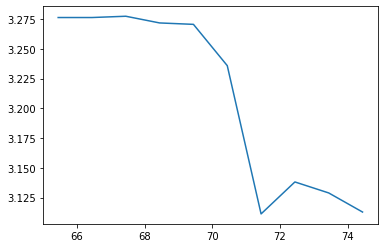

In [24]:
values = dataset_og.loc[[1146]]
values.drop(['ID'], axis=1, inplace=True)
age = values.iat[0,1]
years = 10
pred= []
ages = []

values = values.assign(Measurement_Age_x=[age])
values.head()

for x in range(0,years):
    values['Measurement_Age_x'] = values['Measurement_Age_x'].add(365)
    age2 = values.iat[0,-1]
    x = RFR_model_sph_far_r.predict(values)
    ages.append(age2)
    pred.append(x[0])
        
print(pred)
ages = [x / 365 for x in ages]
plt.plot(ages, pred)

In [25]:
X_train.head()

,Sex,Measurement_Age_x,Add_x,Sph-Far-R_x,Cyl-Far-R_x,Axis-Far-R_x,Sph-Close-R_x,Cyl-Close-R_x,Axis-Close-R_x,Sph-Far-L_x,Cyl-Far-L_x,Axis-Far-L_x,Sph-Close-L_x,Cyl-Close-L_x,Axis-Close-L_x,Measurement_Age
14942,0,20855,2.5,1.00,0.0,0.0,3.50,0.0,0.0,1.00,0.0,0.0,3.50,0.0,0.0,22223
26370,1,20851,0.0,0.00,0.0,0.0,1.75,0.0,0.0,0.00,0.0,0.0,1.75,0.0,0.0,21966
1850,0,18588,0.0,0.00,0.0,0.0,2.25,0.0,0.0,0.00,0.0,0.0,2.25,0.0,0.0,19886
21698,0,3615,0.0,-4.50,0.5,110.0,0.00,0.0,0.0,-5.00,1.0,70.0,0.00,0.0,0.0,4329
13262,0,12055,0.0,-3.25,0.0,0.0,0.00,0.0,0.0,-2.25,0.0,0.0,0.00,0.0,0.0,13217
